# House Price Predictions - Linear Regression

Data - Prices and 79 features describing residential homes in Ames, Iowa. 

Aim - To use regression techniques to predict house prices.  

# 1. Import packages, data and inspect variables

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso, LassoCV, ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [2]:
print(pd.__version__)
print(sns.__version__)
print(np.__version__)

1.1.3
0.11.0
1.19.2


In [3]:
# import data
df_train = pd.read_csv('train.csv')

In [4]:
# inspect the number of variables and types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# Check for unique values and duplicates
UniqueIds = len(set(df_train.Id))
TotalIds = df_train.shape[0]
DuplicateIds = TotalIds - UniqueIds

In [6]:
print('The number of duplicate ids in the data set of ' + str(TotalIds) + ' fields is ' + str(DuplicateIds)+ '.')

The number of duplicate ids in the data set of 1460 fields is 0.


In [7]:
# Id field not needed - drop
df_train.drop('Id', axis=1, inplace=True)

# 2. Data cleaning - replace missing variables & some feature engineering

Using data_description.txt inspect and change:

A. Missing values where common value does not make sense or median/mean will not work as a replacement

B. Categorical features to numbers where there is an order in the categories

C. Numerical values are in fact categories

D. Features which describe very similar characteristics of the property are combined.

In [8]:
df_train.isna().sum().sum()

6965

In [9]:
# A. Fill in missing values/values that don't make sense - first identify columns with na
df_train.columns[df_train.isna().any().tolist()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [10]:
# Descriptive categorical variables of type object, fill na with none (str).  GarageYrBuilt is float
# but using none makes sense as na is likely to mean the property has no garage.

df_train[['Alley', 'MasVnrType', 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1', 
        'BsmtFinType2','Electrical','FireplaceQu','GarageType', 'GarageYrBlt','GarageFinish',
        'GarageQual', 'GarageCond','PoolQC','Fence', 'MiscFeature']] = df_train[['Alley', 
        'MasVnrType', 'BsmtQual','BsmtCond','BsmtExposure', 'BsmtFinType1','BsmtFinType2',
        'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt','GarageFinish',
        'GarageQual', 'GarageCond','PoolQC','Fence','MiscFeature']].fillna(value='None')

# Variables of type float64 replace with 0.
df_train[['LotFrontage','MasVnrArea']] = df_train[['LotFrontage','MasVnrArea']].fillna(value=0)

# Recheck the number of na values
df_train.isna().sum().sum()

0

In [11]:
# Some categorical variables have a description of increasing/decreasing quality or condition.  Replace with numerical values
# to try and gain extra value out of these variables for the model.
dict1 = {'Ex':3, 'Gd':3, 'TA':2, 'Fa':2, 'Po':1}
dict2 = {'Ex':3, 'Gd':3, 'TA':2, 'Fa':2, 'Po':1, 'None': 0}
dict3 = {'GLQ':3, 'ALQ':3, 'BLQ':2, 'Rec':2, 'LwQ':1, 'Unf':1, 'None':0}

df_train[['ExterCond','ExterQual','HeatingQC','KitchenQual']] = df_train[['ExterCond',
        'ExterQual','HeatingQC','KitchenQual']].replace(dict1)    
df_train[['BsmtQual','BsmtCond','FireplaceQu','GarageQual','GarageCond']] = df_train[['BsmtQual',
        'BsmtCond','FireplaceQu','GarageQual','GarageCond']].replace(dict2)
df_train[['BsmtFinType1','BsmtFinType2']] = df_train[['BsmtFinType1','BsmtFinType2']].replace(dict3)
    
df_train = df_train.replace({'LandSlope': {'Sev': 1, 'Mod': 2, 'Gtl': 3},
                           'BsmtExposure': {'Gd':3, 'Av':2, 'Mn':2, 'No':1, 'None': 0},
                           'PoolQC': {'Ex':3, 'Gd':3, 'TA':2, 'Fa':1, 'None':0},
                           'Functional':{'Typ':4,'Min1':4, 'Min2':3, 'Mod':3, 'Maj1':2, 'Maj2':2, 'Sev':1,'Sal':1}})
                           
#Quick check of replacements
df_train[['ExterCond','ExterQual','FireplaceQu','BsmtFinType1','Functional']].tail(5)

,ExterCond,ExterQual,FireplaceQu,BsmtFinType1,Functional
1455,2,2,2,1,4
1456,2,2,2,3,4
1457,3,3,3,3,4
1458,2,2,0,3,4
1459,2,3,0,2,4


In [12]:
if isinstance(df_train, pd.DataFrame):
    print('yes dataframe type')

yes dataframe type


In [13]:
df_train.shape

(1460, 80)

In [14]:
# Reduce the scale of some of the numerical ratings
dict4 =  {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:4, 8:4, 9:5, 10:5} # 'Red_OverallQual', 'Red_OverallCond', 
df_train[['Red_OverallQual', 'Red_OverallCond']] = df_train[['OverallQual', 'OverallCond']].replace(dict4)


In [15]:
# C. Some numerical features are in fact categories
# Some numerical features are actually really categories
df_train = df_train.replace( {"MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"},
                              "MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"}})

In [16]:
df_train.shape

(1460, 82)

In [17]:
# Features which describe very similar characteristics of the property are combined.

In [18]:
df_train['OverallRating'] = df_train['OverallQual'].multiply(df_train['OverallCond'])
df_train['ExterRating'] = df_train['ExterQual'].multiply(df_train['ExterCond'])

df_train['BsmtRating'] = df_train['BsmtQual'].multiply(df_train['BsmtCond'])
df_train['FireplaceRating'] = df_train['Fireplaces'].multiply(df_train['FireplaceQu'])
df_train['GarageRating'] = df_train['GarageQual'].multiply(df_train['GarageCond'])
df_train['PoolRating'] = df_train['PoolQC'].multiply(df_train['PoolArea'])

# Check mult
df_train[['OverallRating','OverallQual','OverallCond','ExterRating','ExterQual',
         'ExterCond', 'BsmtRating','BsmtQual','BsmtCond']].head(5)

,OverallRating,OverallQual,OverallCond,ExterRating,ExterQual,ExterCond,BsmtRating,BsmtQual,BsmtCond
0,35,7,5,6,3,2,6,3,2
1,48,6,8,4,2,2,6,3,2
2,35,7,5,6,3,2,6,3,2
3,35,7,5,4,2,2,6,2,3
4,40,8,5,6,3,2,6,3,2


In [19]:
df_train[['FireplaceRating','Fireplaces','FireplaceQu','GarageRating','GarageQual',
         'GarageCond', 'PoolRating','PoolQC','PoolArea']].tail(5)

,FireplaceRating,Fireplaces,FireplaceQu,GarageRating,GarageQual,GarageCond,PoolRating,PoolQC,PoolArea
1455,2,1,2,4,2,2,0,0,0
1456,4,2,2,4,2,2,0,0,0
1457,6,2,3,4,2,2,0,0,0
1458,0,0,0,4,2,2,0,0,0
1459,0,0,0,4,2,2,0,0,0


In [20]:
df_train.shape

(1460, 88)

# 3. Prepare data - skewness, encode catgorical variables & remove outliers

A. SalePrice - check for skewness and consider log transfrom. Create y from training data.

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

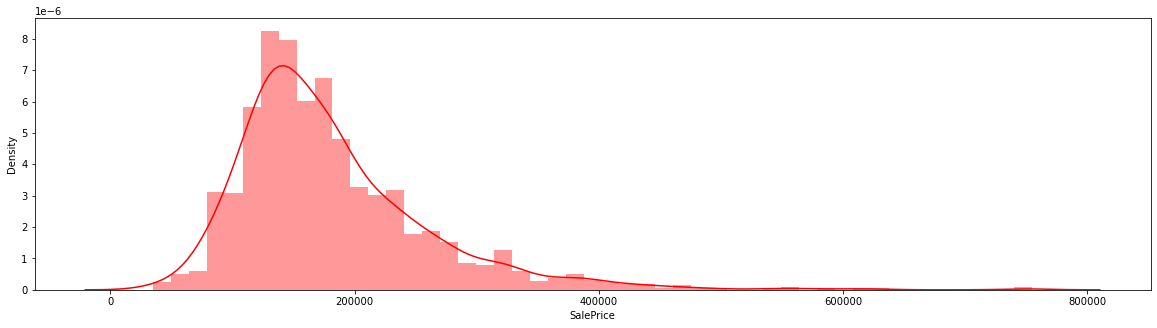

In [21]:
# seaborn histogram of Sale price for distribution.
plt.figure(figsize=(20,5))
sns.distplot(df_train['SalePrice'], color='red')

In [22]:
# Calculate skew
print("Skewness: %f" % df_train['SalePrice'].skew())

Skewness: 1.882876


In [23]:
# Log transform and create y data
df_train.SalePrice = np.log1p(df_train.SalePrice)
y = df_train.SalePrice

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

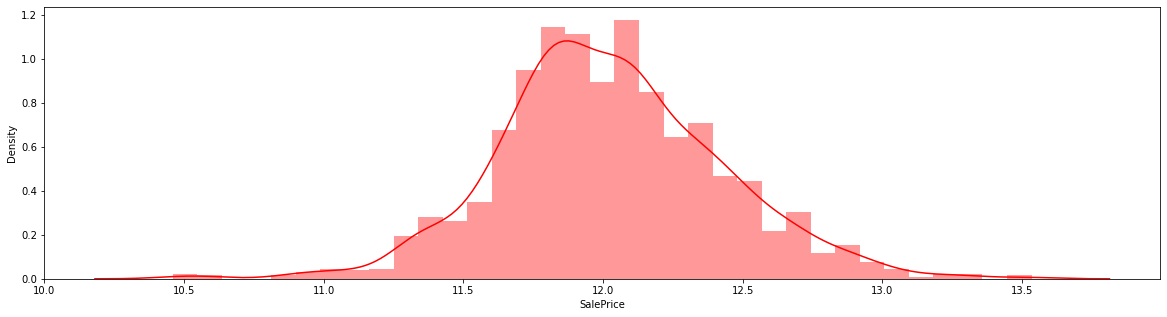

In [24]:
# Replot distribution
plt.figure(figsize=(20,5))
sns.distplot(df_train['SalePrice'], color='red')

B. Categorical features - encode as binary 

In [25]:
# Select the reamining categorical features.
cat_features =  df_train.select_dtypes('object')
cat_features.shape

(1460, 31)

In [26]:
# Use one-hot encoding to create binary features for categorical features.
cat_train = pd.get_dummies(cat_features, drop_first=True) 
cat_train.head(5)

,MSSubClass_SC160,MSSubClass_SC180,MSSubClass_SC190,MSSubClass_SC20,MSSubClass_SC30,MSSubClass_SC40,MSSubClass_SC45,MSSubClass_SC50,MSSubClass_SC60,MSSubClass_SC70,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [27]:
cat_train.shape

(1460, 282)

In [28]:
print('Number of NAs in encoded categorical variables: ' + str(cat_train.isnull().values.sum()))

Number of NAs in encoded categorical variables: 0


C. Continuous features - log transform skewed features

In [29]:
# Select the continuous features
con_train = df_train.select_dtypes(exclude = ['object'])
con_train.shape

(1460, 57)

In [30]:
print('Number of NAs in continuous variables: ' + str(con_train.isnull().values.sum()))

Number of NAs in continuous variables: 0


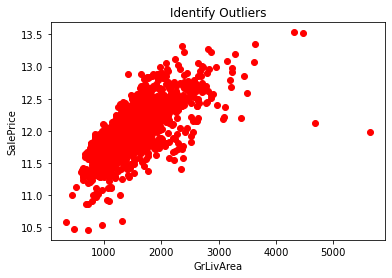

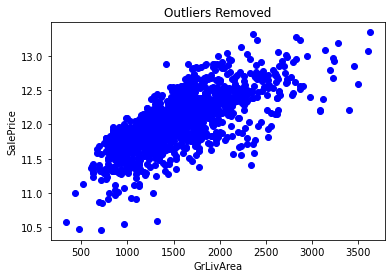

In [31]:
# Outliers - the creator of this data set (http://jse.amstat.org/v19n3/decock.pdf) suggests 'there are
# five observations that an instructor may wish to remove from the data set' in relation to GrLivArea
plt.scatter(con_train.GrLivArea, con_train.SalePrice, c = 'red', marker = 'o')
plt.title('Identify Outliers')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

con_train.drop(con_train[con_train.GrLivArea > 4000].index, inplace=True)

plt.scatter(con_train.GrLivArea, con_train.SalePrice, c = 'blue', marker = 'o')
plt.title('Outliers Removed')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [32]:
# Transform skewed continuous variables 
skewed = con_train.skew(axis=0)
skewed = skewed[abs(skewed) > 0.5]
log_features = skewed.index
con_train[log_features] = np.log1p(con_train[log_features])

In [33]:
# Drop sales price - this is the y data (created  previously)
con_train = con_train.drop(columns = ['SalePrice'])
con_train.shape

(1456, 56)

# 4. Recombine categorical & continuous data 

In [34]:
# Join continuous and categorical features
train = pd.concat([con_train, cat_train], axis = 1)
print('Total number of features: ' + str(train.shape[1]))
print('Number of NAs in all features: ' + str(con_train.isnull().values.sum()))
train.shape

Total number of features: 338
Number of NAs in all features: 0


(1460, 338)

# 5. Linear regression models

In [35]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train (rows, features): " + str(X_train.shape))
print("X_test (rows, features): " + str(X_test.shape))
print("y_train (rows): " + str(y_train.shape))
print("y_test (rows): " + str(y_test.shape))

X_train (rows, features): (1022, 338)
X_test (rows, features): (438, 338)
y_train (rows): (1022,)
y_test (rows): (438,)


In [36]:
num_cols = con_train.columns[con_train.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
#num_cols = num_cols.drop(columns= ['SalePrice'])
num_cols.shape

(56,)

In [37]:
# Use standard scaler to normalize continuous features
scale = StandardScaler()

X_train[num_cols] = scale.fit_transform(X_train[num_cols])
X_test[num_cols] = scale.transform(X_test[num_cols])

In [38]:
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())

### A. Lasso Regression

Below fits the model and discovers the hyperparameters that give the best results using cross-validation.

In [39]:
# The model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=43)
# define model
lasso = LassoCV(alphas=np.arange(0, 1, 0.01), cv=cv, n_jobs=-1)
# fit model
lasso.fit(X_train, y_train)
# best alpha
print('alpha: %f' % lasso.alpha_)

alpha: 0.010000


Prediction

In [40]:
y_train_lasso = lasso.predict(X_train)
y_pred_lasso = lasso.predict(X_test)

In [41]:
# Compute the root-mean-square
rms = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(rms) 

0.1357906728589878


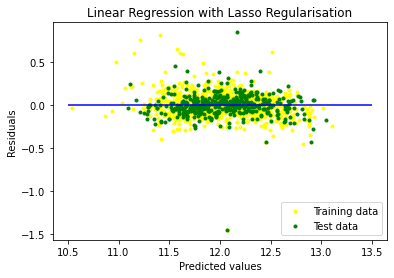

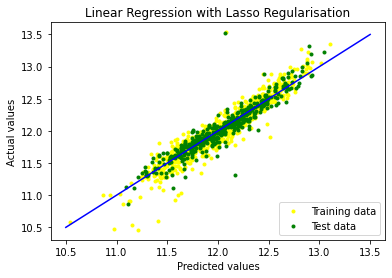

In [42]:
plt.rcParams["figure.facecolor"] = 'white'
# Residuals
plt.scatter(y_train_lasso, y_train_lasso - y_train, c = 'yellow', marker = '.', label = 'Training data')
plt.scatter(y_pred_lasso, y_pred_lasso - y_test, c = 'green', marker = '.', label = 'Test data')
plt.title('Linear Regression with Lasso Regularisation')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'lower right')
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = 'blue')
plt.show()

# Predictions
plt.scatter(y_train_lasso, y_train, c = 'yellow', marker = '.', label = 'Training data')
plt.scatter(y_pred_lasso, y_test, c = 'green', marker = '.', label = 'Test data')
plt.title('Linear Regression with Lasso Regularisation')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.legend(loc = 'lower right')
plt.plot([10.5, 13.5], [10.5, 13.5], c = 'blue')
plt.show()

In [43]:
# Coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
(f'Lasso chose  {(sum(coefs != 0))} features and excluded the other {(sum(coefs == 0))} features')

'Lasso chose  22 features and excluded the other 316 features'

### B. Ridge Regression

In [44]:
# The model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=43)
# define model
ridge = RidgeCV(alphas=np.arange(0, 1, 0.01), cv=cv)
# fit model
ridge.fit(X_train, y_train)
# best alpha
print('alpha: %f' % ridge.alpha_)

alpha: 0.990000


In [45]:
y_train_ridge = ridge.predict(X_train)
y_pred_ridge = ridge.predict(X_test)

In [46]:
# Compute the root-mean-square
rms = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(rms) 

0.14218849518709742


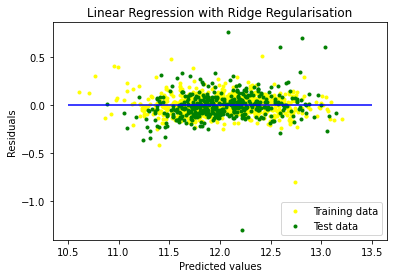

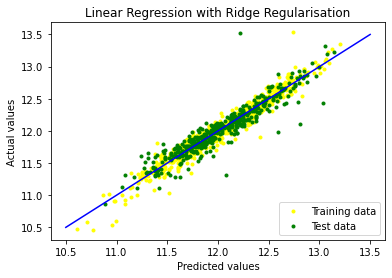

In [47]:
plt.rcParams["figure.facecolor"] = 'white'
# Residuals
plt.scatter(y_train_ridge, y_train_ridge - y_train, c = 'yellow', marker = '.', label = 'Training data')
plt.scatter(y_pred_ridge, y_pred_ridge - y_test, c = 'green', marker = '.', label = 'Test data')
plt.title('Linear Regression with Ridge Regularisation')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'lower right')
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = 'blue')
plt.show()

# Predictions
plt.scatter(y_train_ridge, y_train, c = 'yellow', marker = '.', label = 'Training data')
plt.scatter(y_pred_ridge, y_test, c = 'green', marker = '.', label = 'Test data')
plt.title('Linear Regression with Ridge Regularisation')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.legend(loc = 'lower right')
plt.plot([10.5, 13.5], [10.5, 13.5], c = 'blue')
plt.show()

In [48]:
# Coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
(f'Ridge chose  {(sum(coefs != 0))} features and minimised the other {(sum(coefs == 0))} features')

'Ridge chose  330 features and minimised the other 8 features'

### C. Elastic Net Regression

In [49]:
# Model evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
elasn = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)
# fit model
elasn.fit(X_train, y_train)
# best alpha
print('alpha: %f' % elasn.alpha_)
print('l1_ratio_: %f' % elasn.l1_ratio_)

alpha: 0.010000
l1_ratio_: 0.040000


In [50]:
y_train_elasn = elasn.predict(X_train)
y_pred_elasn = elasn.predict(X_test)

In [51]:
# Compute the root-mean-square
rms = np.sqrt(mean_squared_error(y_test, y_pred_elasn))
print(rms) 

0.12570893722886708


In [52]:
# rmse of 0.12571 approx 1123/4882 on leaderboard

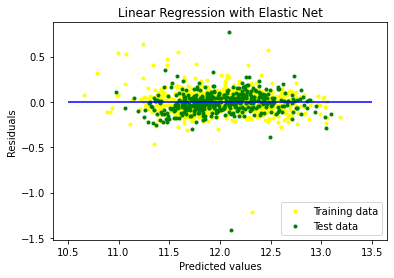

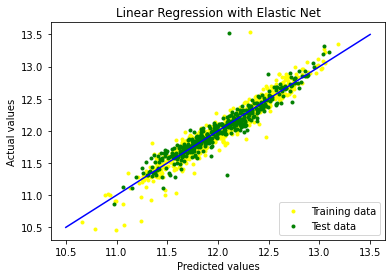

In [53]:
plt.rcParams["figure.facecolor"] = 'white'
# Residuals
plt.scatter(y_train_elasn, y_train_elasn - y_train, c = 'yellow', marker = '.', label = 'Training data')
plt.scatter(y_pred_elasn, y_pred_elasn - y_test, c = 'green', marker = '.', label = 'Test data')
plt.title('Linear Regression with Elastic Net')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'lower right')
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = 'blue')
plt.show()

# Predictions
plt.scatter(y_train_elasn, y_train, c = 'yellow', marker = '.', label = 'Training data')
plt.scatter(y_pred_elasn, y_test, c = 'green', marker = '.', label = 'Test data')
plt.title('Linear Regression with Elastic Net')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.legend(loc = 'lower right')
plt.plot([10.5, 13.5], [10.5, 13.5], c = 'blue')
plt.show()

In [54]:
# Coefficients
coefs = pd.Series(elasn.coef_, index = X_train.columns)
(f'Elastic net chose  {(sum(coefs != 0))} features and excluded or minimised the other {(sum(coefs == 0))} features')

'Elastic net chose  152 features and excluded or minimised the other 186 features'